In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# -------- SETTINGS --------
SEEDS = [42, 43, 44, 45, 46]
ALGORITHMS = ['random_search', 'genetic_algorithm', 'genetic_algorithm_high_gen', 'genetic_algorithm_high_mut', 'evolution_strategy']
SCENARIOS = ['Walker-v0', 'BridgeWalker-v0']
CSV_FOLDER = '../results_structure'
METRIC = 'Best Fitness'  # The column we're analyzing
GENERATION_COL = 'Generation'
FONT_SIZE = 12
plt.rcParams.update({'font.size': FONT_SIZE})
fitness_values = {}

def load_data(algorithm, scenario):
    """
    Load all runs for a specific algorithm and scenario across different seeds
    Returns a list of DataFrames with added 'Seed' column
    """
    base_path = None
    # Handle special case for random_search
    if algorithm == 'random_search':
        base_path = os.path.join(CSV_FOLDER, 'random', 'data')
    elif algorithm == 'genetic_algorithm':
        base_path = os.path.join(CSV_FOLDER, 'ga', 'data')
    elif algorithm == 'genetic_algorithm_high_gen':
        base_path = os.path.join(CSV_FOLDER, 'ga_high_gen', 'data')
    elif algorithm == 'genetic_algorithm_high_mut':
        base_path = os.path.join(CSV_FOLDER, 'ga_high_mut', 'data')
    elif algorithm == 'evolution_strategy':
        base_path = os.path.join(CSV_FOLDER, 'es', 'data')
        
    elif algorithm == 'genetic_algorithm_sin':
        base_path = os.path.join(CSV_FOLDER, 'ga_sin', 'data')
    elif algorithm == 'genetic_algorithm_hop':
        base_path = os.path.join(CSV_FOLDER, 'ga_hop', 'data')
    
    if scenario == 'Walker-v0':
        scenario_path = os.path.join(base_path, 'walker')
    elif scenario == 'BridgeWalker-v0':
        scenario_path = os.path.join(base_path, 'bridge')
    
    dfs = []
    for seed in SEEDS:
        # Other algorithms follow standard pattern
        file_name = f"{algorithm}_{scenario}_seed_{seed}.csv"
        
        file_path = os.path.join(scenario_path, file_name)
        #print(f"Looking for: {file_path}")
        
        if os.path.exists(file_path):
            try:
                df = pd.read_csv(file_path)
                df['Seed'] = seed
                df['Scenario'] = scenario
                dfs.append(df)
                #print(f"Successfully loaded {file_path}")
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
        else:
            print(f"File not found: {file_path}")
    
    return dfs

def get_final_fitness(runs):
    """Extract final fitness values from all runs"""
    return [run[METRIC].iloc[-1] for run in runs]

def friedman_test(*samples):
    """Perform Friedman test with simplified output"""
    stat, p = stats.friedmanchisquare(*samples)
    print(f"\nFriedman Test: χ²={stat:.3f}, p={p:.3f}")
    if p < 0.05:
        print("Significant differences found (p < 0.05)")
    return stat, p

def plot_evolution(all_runs, scenario):
    """Plot fitness evolution with confidence intervals"""
    plt.figure(figsize=(10, 6))
    
    for algo, runs in all_runs.items():
        if not runs:
            continue
            
        # Calculate mean and std across runs
        gens = runs[0][GENERATION_COL]
        fitness = np.array([run[METRIC] for run in runs])
        mean = np.mean(fitness, axis=0)
        std = np.std(fitness, axis=0)
        
        plt.plot(gens, mean, label=algo.replace('_', ' '))
        plt.fill_between(gens, mean-std, mean+std, alpha=0.2)
    
    plt.title(f"Fitness Evolution ({scenario})")
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"fitness_{scenario}.png", dpi=120)
    plt.show()

def main():
    # Load all data
    print("Loading data...")
    data = {
        algo: {
            scen: load_data(algo, scen) 
            for scen in SCENARIOS
        } 
        for algo in ALGORITHMS
    }

    # Analyze each scenario
    for scenario in SCENARIOS:
        print(f"\n===== Analyzing {scenario} =====")
        
        # Get final fitness values for all algorithms
        final_values = {
            algo: get_final_fitness(runs[scenario])
            for algo, runs in data.items()
            if runs[scenario]  # Only if we have data
        }
        
        # Print All values of each algorithm for the scenario and each run and store them in a dictionary
        print("\nAll fitness values:")
        for algo, values in final_values.items():
            fitness_values[algo] = values
            print(f"{algo:15}: {values}")
            
        
        # Perform Friedman test
        friedman_test(*final_values.values())
        
        # Plot evolution
        plot_evolution(
            {algo: data[algo][scenario] for algo in ALGORITHMS},
            scenario
        )
        
        # Show final values
        print("\nFinal fitness values:")
        for algo, values in final_values.items():
            print(f"{algo:15}: {np.mean(values):.3f} ± {np.std(values):.3f}")


Loading data...

===== Analyzing Walker-v0 =====

All fitness values:
random_search  : [1.2494769061386126, 1.458797078355273, 0.935663095868709, 1.1116057909372192, 0.5331627113500048]
genetic_algorithm: [6.285444989317926, 7.552341619530747, 6.0286088398376245, 5.340919402164796, 5.021370060049316]
genetic_algorithm_high_gen: [4.914067558558405, 8.699228059436226, 6.718364544476357, 7.746964948461595, 5.8027460303717495]
genetic_algorithm_high_mut: [5.4771930028975575, 4.419714420313453, 5.81529154115125, 5.190928289411684, 3.960314931110223]
evolution_strategy: [5.554575862351781, 6.61918433261952, 6.158154314320953, 5.916374786793599, 4.403327624322315]

Friedman Test: χ²=15.200, p=0.004
Significant differences found (p < 0.05)


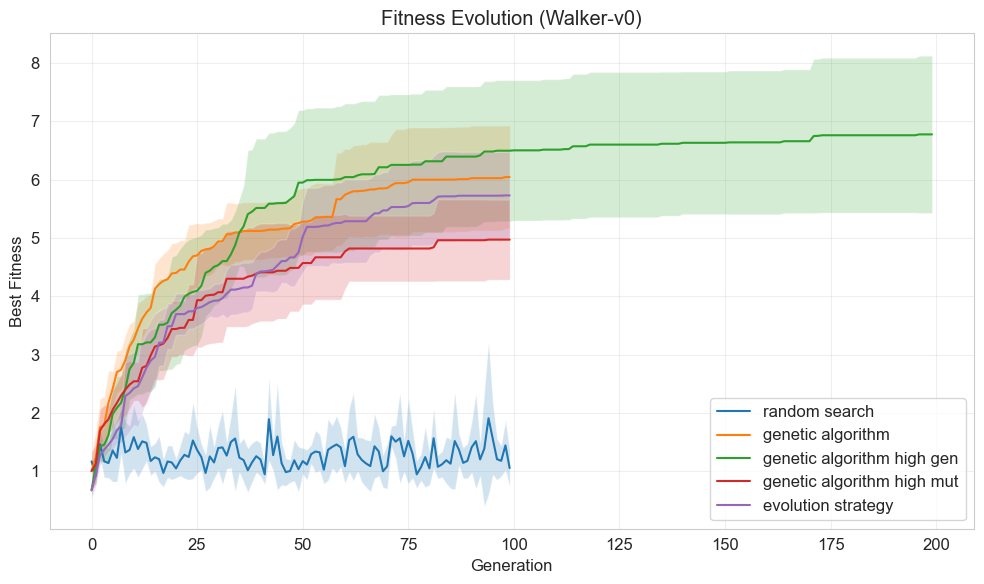


Final fitness values:
random_search  : 1.058 ± 0.313
genetic_algorithm: 6.046 ± 0.880
genetic_algorithm_high_gen: 6.776 ± 1.346
genetic_algorithm_high_mut: 4.973 ± 0.685
evolution_strategy: 5.730 ± 0.748

===== Analyzing BridgeWalker-v0 =====

All fitness values:
random_search  : [1.2494769061386126, 1.458797078355273, 0.935663095868709, 1.1116057909372192, 0.5331627113500048]
genetic_algorithm: [6.285444989317926, 7.552341619530747, 6.0286088398376245, 5.340919402164796, 5.021370060049316]
genetic_algorithm_high_gen: [4.914067558558405, 8.699228059436226, 6.718364544476357, 7.746964948461595, 5.8027460303717495]
genetic_algorithm_high_mut: [5.4771930028975575, 4.419714420313453, 5.81529154115125, 5.190928289411684, 3.960314931110223]
evolution_strategy: [5.554575862351781, 6.61918433261952, 6.158154314320953, 5.916374786793599, 4.403327624322315]

Friedman Test: χ²=15.200, p=0.004
Significant differences found (p < 0.05)


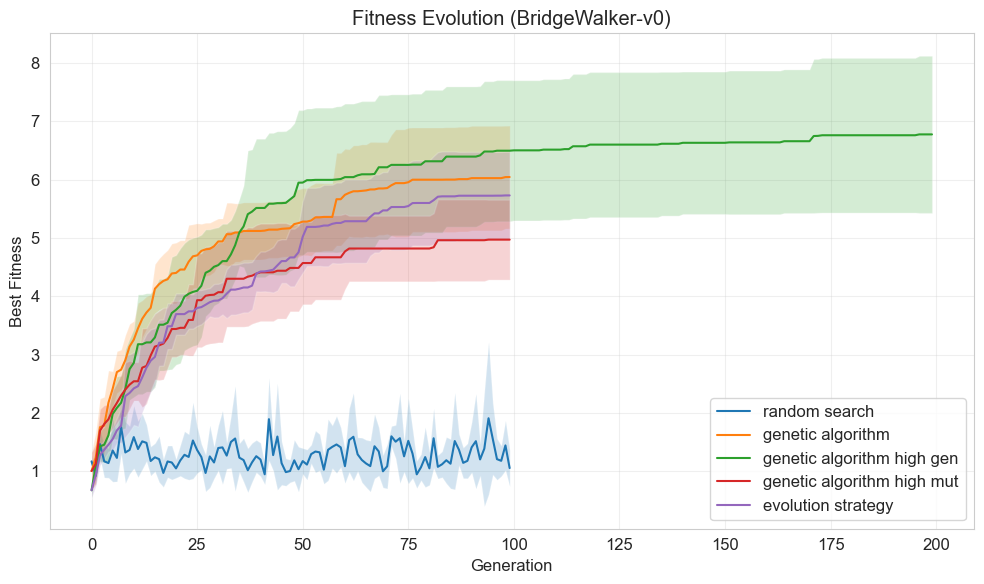


Final fitness values:
random_search  : 1.058 ± 0.313
genetic_algorithm: 6.046 ± 0.880
genetic_algorithm_high_gen: 6.776 ± 1.346
genetic_algorithm_high_mut: 4.973 ± 0.685
evolution_strategy: 5.730 ± 0.748


In [2]:

if __name__ == "__main__":
    sns.set_style("whitegrid")
    plt.rcParams['font.size'] = 12
    main()

Loading data...

===== Analyzing Walker-v0 =====

All fitness values:
genetic_algorithm: [6.285444989317926, 7.552341619530747, 6.0286088398376245, 5.340919402164796, 5.021370060049316]
genetic_algorithm_sin: [3.118803958055706, 3.127223626656462, 3.362290225771115, 2.734784235593724, 3.393846329786749]
genetic_algorithm_hop: [6.243784375583955, 6.526335336167131, 4.419060045784545, 3.808718108559152, 5.828867394108267]

Friedman Test: χ²=8.400, p=0.015
Significant differences found (p < 0.05)


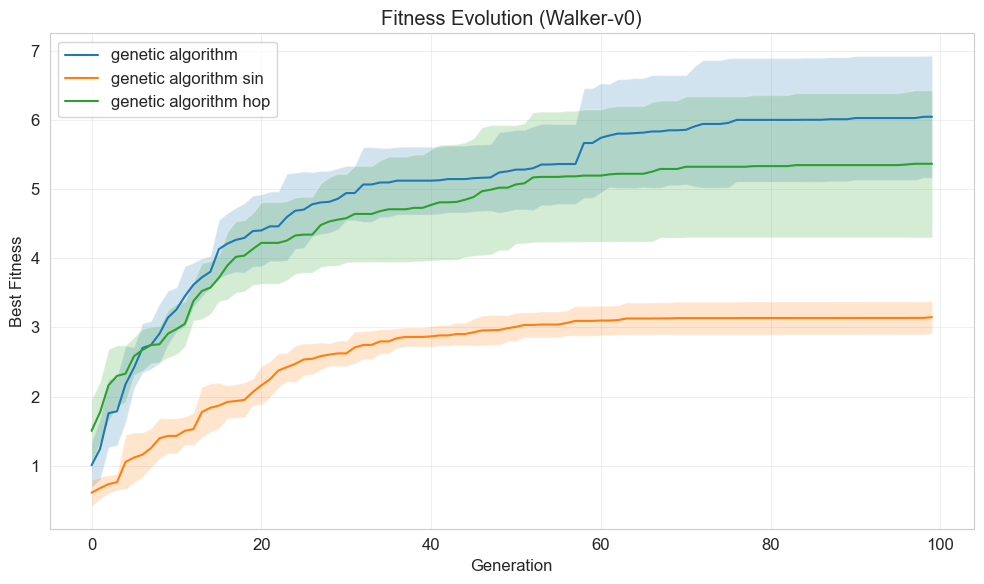


Final fitness values:
genetic_algorithm: 6.046 ± 0.880
genetic_algorithm_sin: 3.147 ± 0.236
genetic_algorithm_hop: 5.365 ± 1.063

===== Analyzing BridgeWalker-v0 =====

All fitness values:
genetic_algorithm: [6.285444989317926, 7.552341619530747, 6.0286088398376245, 5.340919402164796, 5.021370060049316]
genetic_algorithm_sin: [3.118803958055706, 3.127223626656462, 3.362290225771115, 2.734784235593724, 3.393846329786749]
genetic_algorithm_hop: [6.243784375583955, 6.526335336167131, 4.419060045784545, 3.808718108559152, 5.828867394108267]

Friedman Test: χ²=8.400, p=0.015
Significant differences found (p < 0.05)


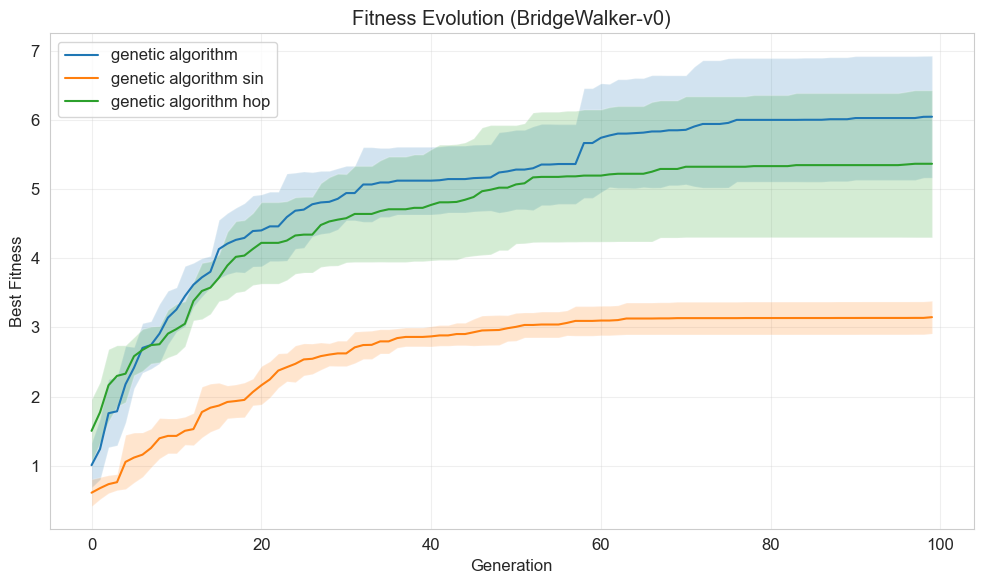


Final fitness values:
genetic_algorithm: 6.046 ± 0.880
genetic_algorithm_sin: 3.147 ± 0.236
genetic_algorithm_hop: 5.365 ± 1.063


In [53]:
ALGORITHMS = ['genetic_algorithm', 'genetic_algorithm_sin', 'genetic_algorithm_hop']

if __name__ == "__main__":
    sns.set_style("whitegrid")
    plt.rcParams['font.size'] = 12
    main()

In [ ]:
from itertools import combinations

def compare_algorithms(algorithm_results, alpha=0.05):
    """
    Compare all algorithm pairs using Wilcoxon signed-rank test
    with Bonferroni correction.
    
    Parameters:
    - algorithm_results: dict {algorithm_name: list_of_fitness_scores}
    - alpha: significance level (default 0.05)
    
    Returns:
    - List of significant comparisons with p-values
    """
    # Get all possible algorithm pairs to compare
    algorithms = list(algorithm_results.keys())
    pairs = list(combinations(algorithms, 2))
    
    # Bonferroni correction
    corrected_alpha = alpha / len(pairs)
    
    print(f"Comparing {len(algorithms)} algorithms ({len(pairs)} pairs)")
    print(f"Significance level: {alpha} (Bonferroni-corrected α = {corrected_alpha:.4f})")
    
    # Store significant results
    significant = []
    
    # Compare each pair
    for alg1, alg2 in pairs:
        # Get the fitness scores for this pair
        data1 = algorithm_results[alg1]
        data2 = algorithm_results[alg2]
        
        # Run Wilcoxon test
        stat, p = stats.wilcoxon(data1, data2)
        
        # Check significance
        is_significant = p < corrected_alpha
        if is_significant:
            significant.append((alg1, alg2, p))
        
        # Print all results (comment out if you only want significant ones)
        print(f"{alg1} vs {alg2}: p = {p:.4f} {'*' if is_significant else ''}")
    
    return significant

if __name__ == "__main__":
    # Your final fitness data (replace with actual data)
    
    # Run comparisons
    significant_pairs = compare_algorithms(fitness_values)
    
    # Print summary
    print("\nSignificant differences found:")
    for alg1, alg2, p in significant_pairs:
        print(f"- {alg1} vs {alg2}: p = {p:.4f}")

Comparing 5 algorithms (10 pairs)
Significance level: 0.05 (Bonferroni-corrected α = 0.0050)
random_search vs genetic_algorithm: p = 0.0625 
random_search vs genetic_algorithm_high_gen: p = 0.0625 
random_search vs genetic_algorithm_high_mut: p = 0.0625 
random_search vs evolution_strategy: p = 0.0625 
genetic_algorithm vs genetic_algorithm_high_gen: p = 0.4375 
genetic_algorithm vs genetic_algorithm_high_mut: p = 0.0625 
genetic_algorithm vs evolution_strategy: p = 0.3125 
genetic_algorithm_high_gen vs genetic_algorithm_high_mut: p = 0.1250 
genetic_algorithm_high_gen vs evolution_strategy: p = 0.1875 
genetic_algorithm_high_mut vs evolution_strategy: p = 0.0625 

Significant differences found:


We performed a Friedman test to determine if there were significant differences between the five algorithms across five matched runs. The test revealed a statistically significant difference (χ² = 15.20, p = 0.004), indicating that at least one algorithm performed differently from the others.

To identify which algorithms differed, we conducted pairwise Wilcoxon signed-rank tests, applying a Bonferroni correction (α = 0.005). While several comparisons showed p-values suggesting potential trends (e.g., GA > ES, p = 0.0625), none reached statistical significance at the corrected threshold. This suggests that although the Friedman test detects overall differences, our current sample size (n = 5) may lack the power to resolve specific pairwise distinctions.

Random Search is consistently underperforming.

GA variants converge faster and reach better scores.

Genetic Algorithm with more generations (green) outperforms others in most generations.

ES and GA high mutation follow close behind.